# Emojis Speak More than Words

GOAL: 
    1. give an "issue word" as an input (ex. ocasio, climate change) and find the most related emoji
    to kinda grasp people's opinions
    2. give any word or a saying and get a emoji that is most related ex. sparkle --> ✨


In [1]:
import pickle
import numpy as np
import pandas as pd

In [ ]:
# read topic words data
from read_tweets import read_tweets
reading = read_tweets()
tweets = reading.emoji_tweets(['is', 'the', 'of', 'to', 'climate change', 'stranger things', 'trump'], 
                              num_batches = 20, num_tweets = 100)

Loading 1 of 20
Loading 2 of 20
Loading 3 of 20
Loading 4 of 20
Loading 5 of 20
Loading 6 of 20
Loading 7 of 20
Loading 8 of 20
Loading 9 of 20


In [3]:
from clean_tweets import clean_tweets
cleaning = clean_tweets()
tweets_df = cleaning.tweets_df(tweets)

[nltk_data] Downloading package stopwords to /Users/sara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
cleaning.top_emojis(tweets_df)

    0    1    2    3    4    5    6    7    8    9   ...   15   16   17   18  \
0    😂    ❤    😭    🔥    😍    🤣    ✨    🙏    ♀    🥺  ...    🤔    🙌    🤷    🚨   
1  764  457  418  270  216  195  161  158  157  150  ...  112  111  110  100   

   19  20  21  22  23  24  
0   🙄   💙   🥰   💚   😩   👀  
1  98  97  94  93  93  91  

[2 rows x 25 columns]


In [89]:
from collections import Counter
tw = [word for word in tweets_df['emoji']]
tw_counts = Counter(tw)
tw_counts = pd.DataFrame.from_dict(tw_counts, orient='index').reset_index()
tw_counts = tw_counts.sort_values(by = 0)

In [101]:
tw_counts[tw_counts[0] == 1]
# 261 emojis with just 1 tweet

11616


,index,0
875,🇺🇦,1
640,🇹🇹,1
208,🇱🇰,1
644,🥯,1
645,🍟,1
646,🤼,1
647,✡,1
637,🍚,1
648,🕎,1
650,🚯,1


too many laughing face...

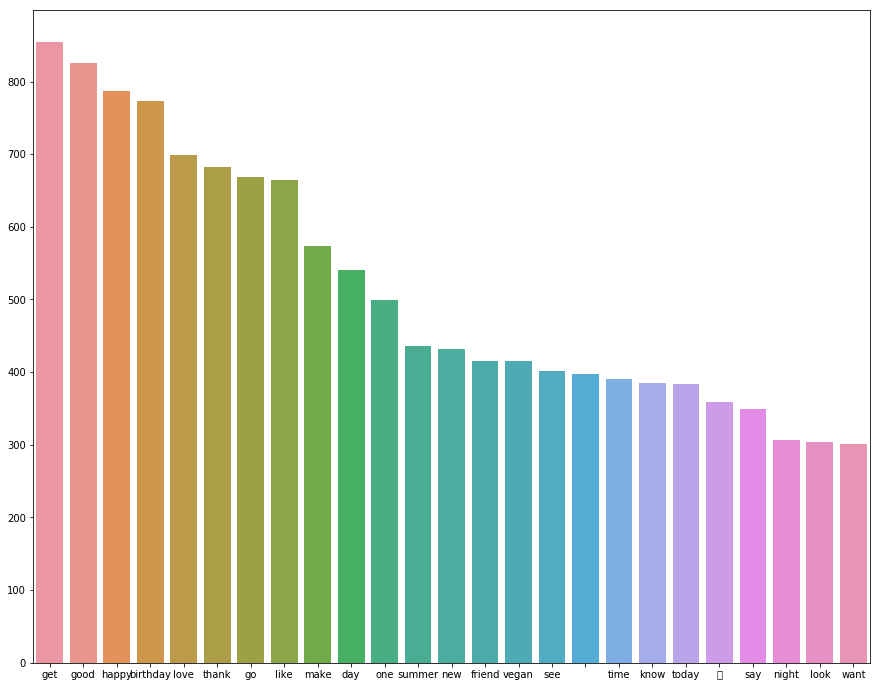

In [7]:
cleaning.top_words(tweets_df)

Let's model tweets with naive bayes and svm algorithms

In [8]:
np.random.seed(123)

In [9]:
print("Working with {} tweets".format(len(tweets_df['tweets'].unique())))

Working with 7492 tweets


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [11]:
X = tweets_df['tweets'].values
y = tweets_df['emoji']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
stopwords = set(list(ENGLISH_STOP_WORDS) + ['rt', 'follow', 'dm', 'https', 'ur', 'll' ,'amp', 'subscribe', 'don', 've', 'retweet', 'im', 'http','lt'])
tfidf = TfidfVectorizer(max_features=10000, max_df = .8, min_df = .001, stop_words = stopwords, ngram_range = (1,2))
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [14]:
# Naive Bayes multinom
nb = naive_bayes.MultinomialNB()
nb.fit(X_train_tfidf, y_train)
# predict the labels on validation dataset
predictions_nb = nb.predict(X_test_tfidf)
# Use accuracy_score function to get the accuracy
nb_score = accuracy_score(predictions_nb, y_test)*100
print("Naive Bayes Accuracy Score -> ", nb_score)

Naive Bayes Accuracy Score ->  8.175559380378658


In [15]:
sgd = SGDClassifier(loss="log", alpha=.0001, max_iter=50, penalty="elasticnet")
sgd.fit(X_train_tfidf, y_train)
# predict the labels on validation dataset
predictions_sgd = nb.predict(X_test_tfidf)
# Use accuracy_score function to get the accuracy
sgd_score = accuracy_score(predictions_sgd, y_test)*100
print("Stochastic Gradient Descent Accuracy Score -> ", sgd_score)

Stochastic Gradient Descent Accuracy Score ->  8.175559380378658


In [16]:
# Naive Bayes gaussian
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train_tfidf.todense(), y_train)
predictions_gnb = gnb.predict(X_test_tfidf.todense())
gnb_score = accuracy_score(predictions_gnb, y_test)*100
print("Gaussian Naive Bayes Accuracy Score -> ", gnb_score)

Gaussian Naive Bayes Accuracy Score ->  2.710843373493976


In [17]:
# SVM
svm = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
svm.fit(X_train_tfidf, y_train)
# predict the labels on validation dataset
predictions_svm = svm.predict(X_test_tfidf)
# Use accuracy_score function to get the accuracy
score = accuracy_score(predictions_svm, y_test)*100
print("SVM Accuracy Score -> ",score)

SVM Accuracy Score ->  9.50946643717728


In [18]:
# prediction
def prediction(model, text, top_n = 5):
    test_tfidf = tfidf.transform([text])
    if model == gnb:
        probs = model.predict_proba(test_tfidf.todense())
        predict_rank = pd.DataFrame({type(model).__name__+' predictions': gnb.classes_, 'probs': probs[0]})
        predict_rank = predict_rank[predict_rank['probs']>0]
        predict_rank = predict_rank.sort_values(by = 'probs', ascending = False)

    else:
        probs = model.predict_proba(test_tfidf.todense())
        predict_rank = pd.DataFrame({type(model).__name__+' predictions': model.classes_, 'probs': probs[0]})
        predict_rank = predict_rank.sort_values(by = 'probs', ascending = False)
    
    return(predict_rank[:top_n].reset_index(drop=True)) 


def print_prediction(text, top_n = 5):
    models = [gnb, sgd, nb, svm]
    df = pd.DataFrame()
    for i in models:
        df = pd.concat([df, prediction(i, text, top_n)], axis=1)
    print('top {} predictions for {} is:'.format(top_n, text))
    return(df)

In [24]:
print_prediction(text = 'climage change', top_n = 10)

top 10 predictions for climage change is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs,MultinomialNB predictions,probs,SVC predictions,probs
0,👣,1.000000e+00,😂,0.015748,😂,0.122820,😂,0.092646
1,🇵🇰,7.332552e-27,😭,0.007078,😭,0.036378,😭,0.032328
2,🌩,7.208924e-31,🤷,0.007072,❤,0.027712,🔥,0.019821
3,🎯,1.401361e-48,🙄,0.006597,🔥,0.026178,♀,0.016102
4,⛈,3.558469e-52,🔥,0.006164,♀,0.021035,🤣,0.015932
5,☠,1.678509e-59,🌎,0.005624,🙄,0.020405,♂,0.015139
6,👎,7.026659e-65,❤,0.004891,🤷,0.019633,🙄,0.013725
7,⛽,1.895324e-66,♂,0.004379,😍,0.018334,😍,0.013611
8,🌳,4.850117e-71,♀,0.004242,🤣,0.017381,🤷,0.012279
9,📶,4.154903e-73,😍,0.004123,♂,0.017132,🤔,0.011499


In [22]:
print_prediction(text = 'birthday', top_n = 5)

top 5 predictions for birthday is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs,MultinomialNB predictions,probs,SVC predictions,probs
0,🕊,9.997362e-01,🎂,0.053740,❤,0.203001,🎉,0.062831
1,🕹,2.288693e-04,🎈,0.039764,🎉,0.087082,🎂,0.038524
2,🤴,3.490436e-05,❤,0.027689,😂,0.060018,❤,0.038468
3,🍩,1.526661e-10,🎉,0.024711,💕,0.039685,✨,0.024414
4,🦅,3.010016e-14,✨,0.020388,😭,0.037130,🎈,0.024001


In [23]:
print_prediction(text = 'nothing makes me happier than a box of chocolate', top_n = 5)

top 5 predictions for nothing makes me happier than a box of chocolate is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs,MultinomialNB predictions,probs,SVC predictions,probs
0,🍏,1.000000e+00,🍫,0.011360,😂,0.038162,😍,0.023555
1,🍩,4.803589e-17,😂,0.009995,😍,0.030350,😭,0.019526
2,🧿,9.968481e-21,😍,0.006867,❤,0.027414,😂,0.018838
3,🍫,3.694865e-43,😭,0.006765,😭,0.026125,🔥,0.018112
4,👅,9.563397e-53,🔥,0.005813,🔥,0.020208,❤,0.016066


In [25]:
print_prediction(text = 'korea', top_n = 10)

top 10 predictions for korea is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs,MultinomialNB predictions,probs,SVC predictions,probs
0,🐳,1.000000e+00,😭,0.014267,😭,0.055699,😭,0.048942
1,🇷🇺,1.795420e-15,😂,0.011087,😂,0.050816,😂,0.027852
2,🔺,1.047740e-44,🔥,0.006631,🔥,0.027429,🔥,0.027415
3,🌏,4.713634e-48,❤,0.005223,❤,0.025530,🙏,0.021471
4,😵,1.071262e-59,🙏,0.004910,🙏,0.019602,❤,0.017784
5,🇰🇷,8.283470e-64,💗,0.004617,✨,0.016830,✨,0.016344
6,🇨🇳,1.084491e-87,😍,0.003975,🥺,0.016193,🥺,0.013516
7,🤟,5.641891e-112,🤣,0.003886,😍,0.015314,😍,0.013362
8,🔗,7.602799e-186,✨,0.003734,🤣,0.014098,🤣,0.012645
9,▪,1.735794e-215,🤦,0.003407,🎉,0.013686,💗,0.012093


In [353]:
print_prediction(text = 'summer', top_n = 5)

top 5 predictions for summer is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs,MultinomialNB predictions,probs,SVC predictions,probs
0,🇯🇵,9.947676e-01,☀,0.042655,😂,0.090822,🔥,0.037339
1,👿,5.150186e-03,🌞,0.015545,😭,0.070845,☀,0.023141
2,📹,8.220641e-05,🔥,0.012588,🔥,0.060972,❤,0.018160
3,😗,4.220170e-12,😎,0.012059,❤,0.060193,😭,0.016876
4,💄,3.684542e-12,😭,0.010211,☀,0.026025,😎,0.012052


In [354]:
print_prediction(text = 'chill', top_n = 5)

top 5 predictions for chill is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs,MultinomialNB predictions,probs,SVC predictions,probs
0,🌕,1.000000e+00,😂,0.026298,😂,0.086758,😂,0.083344
1,☄,2.640130e-63,❤,0.010393,❤,0.047165,❤,0.042187
2,🏖,7.144504e-86,😭,0.005917,😭,0.024008,😭,0.031528
3,🐯,6.791571e-116,🔥,0.005781,😍,0.019873,🔥,0.025283
4,🤯,4.686846e-301,😍,0.004487,🔥,0.018456,😍,0.022337


In [355]:
print_prediction(text = 'netflix and chill', top_n = 5)

top 5 predictions for netflix and chill is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs,MultinomialNB predictions,probs,SVC predictions,probs
0,😍,1.0,😂,0.019823,😂,0.053803,😂,0.068401
1,NaN,NaN,❤,0.008911,❤,0.044824,❤,0.039134
2,NaN,NaN,😭,0.006047,😍,0.022914,😭,0.031259
3,NaN,NaN,🔥,0.005656,😭,0.021411,🔥,0.023946
4,NaN,NaN,🙏,0.005341,🔥,0.017251,😍,0.023436


I am really liking the GaussianNB model although it has a very low accuracy score, it's giving out emojis that are more semantically relevant. However, when its given words that are not prevalent in the training set, it has very low performance. Perhaps if it is combined with the SGD classifier, it will be better?
It is hard to train because we cannot just rely on improving metric performance. The model seems to guess the most common emojis.

- need to deal with imbalanced data
- ensemble models
- more data...

In [26]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

Using TensorFlow backend.


In [28]:
print(X_train_tfidf.shape, len(y_train))

(9292, 1220) 9292


In [47]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train_tfidf, y_train)
print(X_train_subsample.shape)
print(len(y_train_subsample))

(822, 1220)
822


In [132]:
from imblearn.under_sampling import EditedNearestNeighbours
enn_mode = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)
X_train_enn_mode, y_train_enn_mode = enn_mode.fit_sample(X_train_tfidf, y_train)

In [165]:
X_train_enn_mode

<1000x1220 sparse matrix of type '<class 'numpy.float64'>'
	with 4881 stored elements in Compressed Sparse Row format>

In [135]:
# Naive Bayes gaussian
gnb_under = naive_bayes.GaussianNB()
gnb_under.fit(X_train_enn_mode.todense(), y_train_enn_mode)
predictions_gnb = gnb_under.predict(X_test_tfidf.todense())
gnb_score = accuracy_score(predictions_gnb, y_test)*100
print("Gaussian Naive Bayes Accuracy Score -> ", gnb_score)

Gaussian Naive Bayes Accuracy Score ->  2.710843373493976


In [48]:
sgd_under = SGDClassifier(loss="log", alpha=.0001, max_iter=50, penalty="elasticnet")
sgd_under.fit(X_train_enn, y_train_enn)
# predict the labels on validation dataset
predictions_sgd = sgd_under.predict(X_test_tfidf)
# Use accuracy_score function to get the accuracy
sgd_score = accuracy_score(predictions_sgd, y_test)*100
print("Stochastic Gradient Descent Accuracy Score -> ", sgd_score)

Stochastic Gradient Descent Accuracy Score ->  8.175559380378658


In [50]:
# prediction
def prediction(model, text, top_n = 5):
    test_tfidf = tfidf.transform([text])
    if model == gnb:
        probs = model.predict_proba(test_tfidf.todense())
        predict_rank = pd.DataFrame({type(model).__name__+' predictions': gnb.classes_, 'probs': probs[0]})
        predict_rank = predict_rank[predict_rank['probs']>0]
        predict_rank = predict_rank.sort_values(by = 'probs', ascending = False)

    else:
        probs = model.predict_proba(test_tfidf.todense())
        predict_rank = pd.DataFrame({type(model).__name__+' predictions': model.classes_, 'probs': probs[0]})
        predict_rank = predict_rank.sort_values(by = 'probs', ascending = False)
    
    return(predict_rank[:top_n].reset_index(drop=True)) 


def print_prediction(text, models = [gnb_under, sgd_under], top_n = 5):
    df = pd.DataFrame()
    for i in models:
        df = pd.concat([df, prediction(i, text, top_n)], axis=1)
    print('top {} predictions for {} is:'.format(top_n, text))
    return(df)

In [139]:
print_prediction(text = 'climate change', top_n = 5)

top 5 predictions for climate change is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs
0,⛈,1.000000e+00,⛈,0.123898
1,⛽,5.400762e-78,☀,0.069170
2,🇪🇺,2.817604e-107,🌎,0.063339
3,🌊,6.834355e-130,🌲,0.034050
4,🌎,1.028445e-163,⏳,0.028312


In [141]:
print_prediction(text = 'vegan', top_n = 5)

top 5 predictions for vegan is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs
0,✊,1.000000e+00,🌱,0.280427
1,🤔,1.143800e-32,🌈,0.134722
2,🍦,4.761708e-64,🌳,0.027512
3,💪,2.633299e-83,🌞,0.025152
4,🌞,6.168140e-89,🌟,0.020770


In [142]:
print_prediction(text = 'trump', top_n = 5)

top 5 predictions for trump is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs
0,👶,1.000000e+00,👶,0.190578
1,❗,3.756445e-74,🇺🇸,0.056917
2,🌈,4.446514e-158,✝,0.023003
3,🇺🇸,1.189013e-175,❗,0.014842
4,1️⃣,0.000000e+00,🌈,0.012791


In [163]:
print_prediction(text = 'summer', top_n = 5)

top 5 predictions for summer is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs
0,❄,1.000000e+00,⚡,0.165451
1,⚡,4.681419e-18,☀,0.153858
2,↘,4.110949e-21,🔥,0.073146
3,🌡,1.795130e-22,✏,0.046189
4,💦,7.767222e-32,😂,0.021251


In [172]:
print_prediction(text = 'nothing makes me happier than a box of chocolate', top_n = 5)

top 5 predictions for nothing makes me happier than a box of chocolate is:


,GaussianNB predictions,probs,SGDClassifier predictions,probs
0,🍰,1.0,🍊,0.048638
1,1️⃣,0.0,🍰,0.021504
2,👁,0.0,❤,0.012316
3,🐊,0.0,😂,0.011980
4,🐋,0.0,♂,0.008464


I liked the results of SGD after EditedNearestNeighbours. However, after resampling, we only have 1000 datasets.

In [252]:
class model_emoji(object):
    
    def __init__(self):
        np.random.seed(1)
        self.X = tweets_df['tweets'].values
        self.y = tweets_df['emoji']
        self.stopwords = set(list(ENGLISH_STOP_WORDS) + ['rt', 'follow', 'dm', 'https', 'ur', 'll' ,'amp', 'subscribe', 'don', 've', 'retweet', 'im', 'http','lt'])

    
    def tfidf(self, max_features=10000, max_df = .8, min_df = .001, ngram_range = (1,2)):
        
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        tfidf = TfidfVectorizer(max_features= max_features, max_df = max_df, min_df = min_df, 
                                stop_words = self.stopwords, ngram_range = ngram_range)
        tfidf.fit(X_train)
        X_train_tfidf = tfidf.transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)
        return(X_train_tfidf, X_test_tfidf)

    def gnb_model(self):

        X_train_tfidf, X_test_tfidf = self.tfidf()
        gnb = naive_bayes.GaussianNB()
        gnb.fit(X_train_tfidf.todense(), y_train)
        predictions_gnb = gnb.predict(X_test_tfidf.todense())
        score = accuracy_score(predictions_gnb, y_test)*100
        print("Gaussian Naive Bayes Accuracy Score -> ", score)
        return(gnb)
                                    
    def sgd_model(self):
        
        X_train_tfidf, X_test_tfidf = self.tfidf()
        sgd = SGDClassifier(loss="log", alpha=.0001, max_iter=50, penalty="elasticnet")
        sgd.fit(X_train_tfidf, y_train)
        # predict the labels on validation dataset
        predictions_sgd = nb.predict(X_test_tfidf)
        # Use accuracy_score function to get the accuracy
        sgd_score = accuracy_score(predictions_sgd, y_test)*100
        print("Stochastic Gradient Descent Accuracy Score -> ", sgd_score)
        return(sgd)
    
    # prediction
    def prediction(self, model, text, top_n = 5):
        test_tfidf = tfidf.transform([text])
        if model == gnb:
            probs = model.predict_proba(test_tfidf.todense())
            predict_rank = pd.DataFrame({type(model).__name__+' predictions': gnb.classes_, 'probs': probs[0]})
            predict_rank = predict_rank[predict_rank['probs']>0]
            predict_rank = predict_rank.sort_values(by = 'probs', ascending = False)

        else:
            probs = model.predict_proba(test_tfidf.todense())
            predict_rank = pd.DataFrame({type(model).__name__+' predictions': model.classes_, 'probs': probs[0]})
            predict_rank = predict_rank.sort_values(by = 'probs', ascending = False)

        return(predict_rank[:top_n].reset_index(drop=True)) 


    def print_prediction(self, models, text, top_n = 5):
        
        df = pd.DataFrame()
        for i in models:
            df = pd.concat([df, prediction(i, text, top_n)], axis=1)
        print('top {} predictions for {} is:'.format(top_n, text))
        return(df)
    
if __name__ == '__main__':
    
    emoji = model_emoji()
    models = [emoji.gnb_model(), emoji.sgd_model()]

Gaussian Naive Bayes Accuracy Score ->  2.6759167492566895
Stochastic Gradient Descent Accuracy Score ->  8.754542451271886
